# Spatialdata - A quick introduction 

This tutorial provides a quick overview over key functionalities of the spatialdata format. This includes 

1. Data modalities
3. Plotting, and 
4. Visualization in napari image viewers. 

For detailed explanations and tutorials, check out the official [documentation](https://spatialdata.scverse.org/en/latest/index.html) 


## Getting started

In the following, we will just explore the spatialdata format a little more. Note that you should also checkout the official documentation [documentation](https://spatialdata.scverse.org/en/latest/index.html), and especially the tutorials on the spatialdata format

- [Tutorial 1](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/models1.html)

 and  spatialelements

- [Tutorial 2](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/models2.html)

## Modules

In [1]:
import numpy as np
import shapely
import geopandas
import matplotlib.pyplot as plt

import spatialdata as sd
from spatialdata.models import Image2DModel

import spatialdata_plot
from napari_spatialdata import Interactive

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
%%capture
spatialdata_plot

## Data

Let's get a built-in mock dataset from spatialdata

In [3]:
sdata = sd.datasets.blobs(extra_coord_system="second_coordinate_system")

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/spatialdata/models/models.py:1048: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


## Read/Write 

Spatialdata has a native on-disk format, based on the `.zarr` standard, that can be used to store the data. De-facto, .zarr stores all data in a directory with subdirectories and specific metadata files. (.zattrs)


```python
# Write spatialdata 
sdata.write(path)

# Read spatialdata 
sdata = sd.read_zarr(path)
```

## Access attributes

Let's explore the structure of the spatialdata object. You can see that the dataset contains multiple attributes 

In [4]:
sdata

SpatialData object
├── Images
│     ├── 'blobs_image': DataArray[cyx] (3, 512, 512)
│     └── 'blobs_multiscale_image': DataTree[cyx] (3, 512, 512), (3, 256, 256), (3, 128, 128)
├── Labels
│     ├── 'blobs_labels': DataArray[yx] (512, 512)
│     └── 'blobs_multiscale_labels': DataTree[yx] (512, 512), (256, 256), (128, 128)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     ├── 'blobs_circles': GeoDataFrame shape: (5, 2) (2D shapes)
│     ├── 'blobs_multipolygons': GeoDataFrame shape: (2, 1) (2D shapes)
│     └── 'blobs_polygons': GeoDataFrame shape: (5, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (26, 3)
with coordinate systems:
    ▸ 'global', with elements:
        blobs_image (Images), blobs_multiscale_image (Images), blobs_labels (Labels), blobs_multiscale_labels (Labels), blobs_points (Points), blobs_circles (Shapes), blobs_multipolygons (Shapes), blobs_polygons (Shapes)
    ▸ 'second_coordinate_system', with elements:
 

You can access these attributes as class attributes (output hidden)

In [5]:
%%capture
# Access `images`
sdata.images

Their contents behave like a dictionary (output hidden)

In [6]:
%%capture
# Access the `blobs_image` layer in `.images`
sdata.images["blobs_image"]

## Images
Images are stored as `xarray.DataArrays` (or, in case of pyramidal/multiscale images as `xarray.DataTree`). `xarray` supports the *lazy loading* of data via its `dask` interface, i.e. it only loads the parts of the image that are required for your computations. This allows users to store image data that is significanly larger than their memory.

<!-- The `xarray` builds on NumPy and Pandas, but adds adds support for annotated indexes etc., making it especially useful for scientific and data-intensive applications. It works seamlessly with Dask for parallel and out-of-core computations, making it scalable for large datasets. -->

In [7]:
type(sdata.images["blobs_image"])

xarray.core.dataarray.DataArray

Images have the dimensions $(c, y, x)$, where $c$ is the number of channels (e.g $c=3$ for RGB images, $c=C$ for $C$ different fluorescence channels), $y$ the number of rows, and $x$ the number of columns. 

In [8]:
sdata.images["blobs_image"]

<xarray.DataArray 'image' (c: 3, y: 512, x: 512)> Size: 6MB
dask.array<array, shape=(3, 512, 512), dtype=float64, chunksize=(3, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 24B 0 1 2
  * y        (y) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
  * x        (x) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
Attributes:
    transform:  {'global': Identity , 'second_coordinate_system': Identity }

### Visualise
Let's plot the image

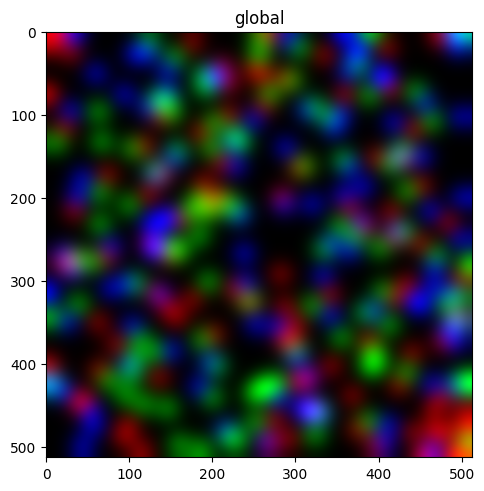

In [9]:
sdata.pl.render_images("blobs_image").pl.show(coordinate_systems="global")

## Shapes

Shapes represent vectorized annotations. This means that each shape is defined as a set of points in a coordinate space. For example to define a small triangle as vectorized shape, you would define it with 4 points (3 unique points and 1 point to close the loop):

(Pseudocode)
```None
triangle := {
    Point1(0, 0), 
    Point2(1, 0),
    Point3(0, 1),
    Point4(0, 0)
    }
```

Spatialdata stores such vectorized annotations in its `.shapes` attribute. The shapes attribute can store different types of shapes, including Polygons (arbitrary shapes) and Points. The shapes attribute can store multiple distinct and independent spatial elements. 

In [10]:
# Access shapes (3 independent elements: 'blobs_circles', 'blobs_polygons', 'blobs_multipolygons')
list(sdata.shapes.keys())

['blobs_circles', 'blobs_polygons', 'blobs_multipolygons']

Each spatialelement is represented as `geopandas.GeoDataFrame`

In [11]:
sdata.shapes["blobs_polygons"]

,geometry
0,"POLYGON ((340.197 258.214, 316.177 197.065, 29..."
1,"POLYGON ((284.141 420.454, 267.249 371.319, 25..."
2,"POLYGON ((203.195 229.528, 285.506 204.414, 19..."
3,"POLYGON ((240.46 196.846, 227.206 188.623, 149..."
4,"POLYGON ((446.703 349.433, 421.086 258.9, 369...."


Let's plot the data 

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


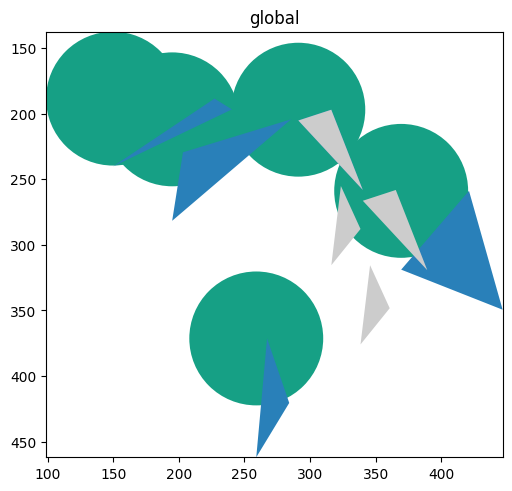

In [12]:
(
    sdata.pl.render_shapes("blobs_circles", alpha=0.5, color="#16A085")  # green
    .pl.render_shapes("blobs_polygons", alpha=0.5, color="#2980B9")  # blue
    .pl.render_shapes("blobs_multipolygons", alpha=0.5, color="#cccccc")  # gray
    .pl.show(coordinate_systems="global")
)

#### Background - Shapes representation in spatialdata

##### shapely

spatialdata uses [`shapely`](https://shapely.readthedocs.io/en/stable/) to define the shapes. We can define our own shape

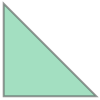

In [13]:
triangle = shapely.Polygon([[0, 0], [1, 0], [0, 1], [0, 0]])
triangle

##### Geopandas 
Spatialdata stores multiple shape annotations as [`geopandas.GeoDataFrame`](https://geopandas.org). 

`geopandas.GeoDataFrame`s behave exactly like a pandas dataframe, except that they support spatial data in a designated `geopandas.GeoSeries` column (usually denoted with `geometry`)
 
We can add the previously defined shape to a geopandas dataframe:

In [14]:
geodf = geopandas.GeoDataFrame(data={"name": ["triangle", "triangle2"]}, geometry=[triangle, triangle])
geodf

,name,geometry
0,triangle,"POLYGON ((0 0, 1 0, 0 1, 0 0))"
1,triangle2,"POLYGON ((0 0, 1 0, 0 1, 0 0))"


In [15]:
# Geopandas behaves like pandas. E.g. Select the first row in the geodataframe
geodf.iloc[[0]]

,name,geometry
0,triangle,"POLYGON ((0 0, 1 0, 0 1, 0 0))"


### Tables 

Tables are used in spatialdata to store omics modalities. Under the hood, tables are represented by an [`anndata`](https://anndata.readthedocs.io) object. Anndata is commonly used to store -omics data as it provides functionalities to jointly anlayse the actual measurements and associated metadata. 

#### !!! Tables support by DVP IO 
DVP IO does currently not provide reading functionalities for proteomics data. This feature will be introduced in early 2025

In [16]:
sdata.tables["table"]

AnnData object with n_obs × n_vars = 26 × 3
    obs: 'instance_id', 'region'
    uns: 'spatialdata_attrs'

Get observation-specific metadata 

In [17]:
adata = sdata.tables["table"]

adata.obs.head()

,instance_id,region
1,1,blobs_labels
2,2,blobs_labels
3,3,blobs_labels
4,4,blobs_labels
5,5,blobs_labels


Get variable-specific metadata

In [18]:
adata.var.head()

""
channel_0_sum
channel_1_sum
channel_2_sum


## Assigning values 

We can also add new attributes to a spatialdata object. To assure the compatibility of data with its format, `spatialdata` implements `spatialdata.models` classes, that define required attributes and processing rules for the different types of data. To assign a new object to spatialdata, we need to parse it with the suitable model class. For details, please see  

- [Tutorial 2](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/models2.html)

### Example 
Say, that we would like to add another image to our spatialdata object. Let's define a small 100 px x 100px RGB image (all white) as array and pass it to spatialdata.

In [19]:
# Define new image (all white, 3 channels [RGB])
new_image = np.zeros(shape=(100, 100, 3))

We cannot immediately assign this image to spatialdata. This will fail:

In [20]:
try:
    # This code block fails
    sdata["new_image"] = new_image
except TypeError as e:
    print(f"TypeError: {e}")

TypeError: Unsupported type <class 'numpy.ndarray'>


Instead, we first have to parse the image with the designated model class `spatialdata.models.Image2DModel`

In [21]:
new_image_parsed = Image2DModel.parse(
    new_image,
    dims=("x", "y", "c"),  # define axes of image (x, y, channels)
    c_coords=("r", "g", "b"),  # optional: name channels
)


# Assign image to existing spatialdata, this works
sdata.images["new_image"] = new_image_parsed

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


We have to proceed similarly for other attributes

- .tables: `spatialdata.models.TableModel`
- .shapes: `spatialdata.models.ShapesModel`

## Plotting

As showcased above, spatialdata implements plotting functionalities that allow you to visualize your omics dataset in static images. To do so, spatialdata relies on its extension package [`spatialdata_plot`](https://spatialdata.scverse.org/projects/plot/en/latest/). Make sure to check out its [documentation](https://spatialdata.scverse.org/projects/plot/en/latest/)

`spatialdata_plot` can be used by employing the `.pl` accessor, followed by a `render_<attribute>` command. 
To show the final plot, call `.pl.show()`

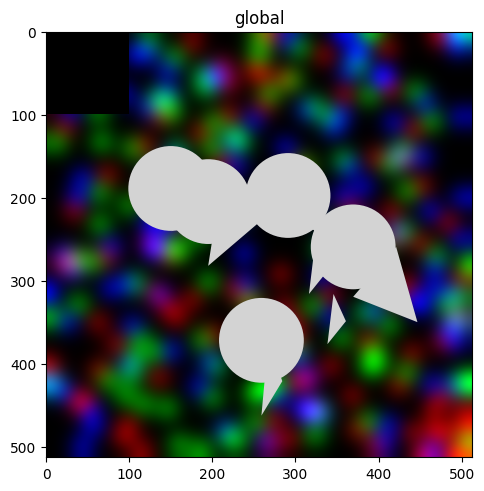

In [23]:
(sdata.pl.render_images().pl.render_shapes().pl.show(coordinate_systems="global"))

### Interactive viewing in Napari

You can inspect the data in napari using the `napari_spatialdata` plugin. For details, take a look at the official [documentation](https://spatialdata.scverse.org/projects/napari/en/latest/index.html)

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2024-12-14 12:48:34.302 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2024-12-14 12:48:34.303 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2024-12-14 12:48:34.608 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2024-12-14 12:48:34.612 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2024-12-14 12:48:34.851 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2024-12-14 12:48:34.855 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2024-12-14 12:48:34.861 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.


(np.float64(-0.5), np.float64(3023.5), np.float64(1885.5), np.float64(-0.5))

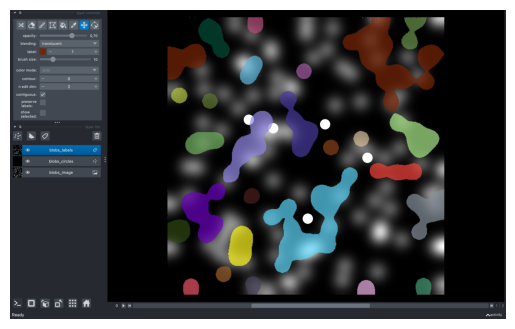

2024-12-14 12:48:35.678 python[80101:8939254] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-14 12:48:35.678 python[80101:8939254] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [24]:
# Start session
interactive = Interactive(sdata)

# # Basic viz:
interactive.add_element("blobs_image", element_coordinate_system="global")
interactive.add_element("blobs_circles", element_coordinate_system="global")
interactive.add_element("blobs_labels", element_coordinate_system="global")


# If you would like to explore it locally, uncomment the following line:
# interactive.run()

# Visualize screenshot
screenshot = interactive.screenshot()
plt.imshow(screenshot)
plt.axis("off")